In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

ImportError: No module named 'seaborn'

In [5]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
# from game import VDMotorEstimationSolver

# Ground truth motor

In [6]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0))
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


# Dataset

In [7]:
n_points=10
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]

# Estimate motor
## No noise

### 5 residuals

In [21]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_difference_residual_block(a,b)
# mes.set_parameterization('BIVECTOR_GENERATOR')
mes.set_parameterization('CAYLEY')
mes.linear_solver_type = 'DENSE_QR'
(em_point_5_res, summary_point_5_res, _) = mes.solve()
print(summary_point_5_res['brief_report'])

Ceres Solver Report: Iterations: 20, Initial cost: 3.059006e+01, Final cost: 9.588204e-19, Termination: CONVERGENCE


In [22]:
em_point_5_res

Mot: [ 0.87 -4.4e-11 -0.5 3.2e-11 -0.68 -0.43 -0.18 -0.25 ]

### 3 residuals

In [9]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
# mes.function_tolerance = 1e-16
(em_point_3_res, summary_point_3_res, _) = mes.solve()
print(summary_point_3_res['brief_report'])

Ceres Solver Report: Iterations: 4, Initial cost: 2.450990e+01, Final cost: 7.099457e-19, Termination: CONVERGENCE


### 1 residual

In [10]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_point_1_res, summary_point_1_res, _) = mes.solve()
print(summary_point_1_res['brief_report'])
print(em_point_1_res)

Ceres Solver Report: Iterations: 14, Initial cost: 3.845491e+01, Final cost: 4.001523e-16, Termination: CONVERGENCE
Mot: [ 0.87 -1.4e-08 -0.5 -1.1e-07 -0.68 -0.43 -0.18 -0.25 ]


### Plots

In [11]:
sns.set_style('whitegrid')
sns.set_context('paper')

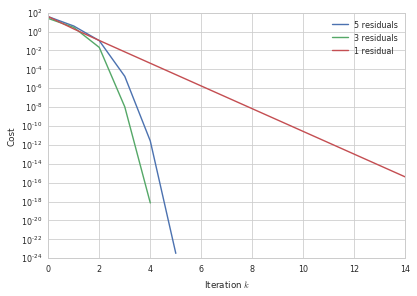

In [12]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_point_5_res['iterations'])['cost'], label=r'5 residuals')
ax.plot(pd.DataFrame(summary_point_3_res['iterations'])['cost'], label=r'3 residuals')
ax.plot(pd.DataFrame(summary_point_1_res['iterations'])['cost'], label=r'1 residual')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('../plots/points-nonoise.pdf')

## Noise

In [13]:
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

### 3 residuals

In [14]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b_noisy):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
# mes.function_tolerance = 1e-16
(em_point_3_res_noise, summary_point_3_res_noise, _) = mes.solve()
print(summary_point_3_res['brief_report'])
print(em_point_3_res_noise)

Ceres Solver Report: Iterations: 4, Initial cost: 2.450990e+01, Final cost: 7.099457e-19, Termination: CONVERGENCE
Mot: [ 0.86 -0.011 -0.51 -0.019 -0.68 -0.44 -0.17 -0.24 ]


### Valkenburg and Dorst

In [15]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a,points_b_noisy)
vd_em_points_noise = vd.solve()
print(vd_em_points_noise)

Mot: [ 0.86 -0.011 -0.51 -0.019 -0.68 -0.44 -0.17 -0.24 ]


In [16]:
mes = MotorEstimationSolver(vd_em_points_noise)
for a, b in zip(points_a, points_b_noisy):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(_, summary_vd, _) = mes.solve()
print(summary_vd['brief_report'])

Ceres Solver Report: Iterations: 0, Initial cost: 1.229881e-01, Final cost: 1.229881e-01, Termination: CONVERGENCE


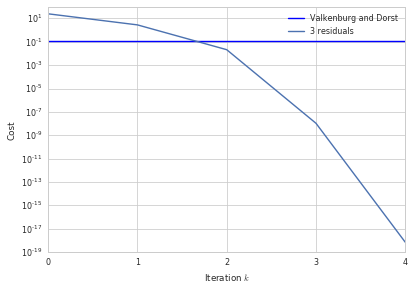

In [47]:
fig, ax = plt.subplots(1)
plt.axhline(y=summary_vd['iterations'][0]['cost'], label=r'Valkenburg and Dorst')

ax.plot(pd.DataFrame(summary_point_3_res['iterations'])['cost'], label=r'3 residuals')

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('../plots/points_noise.pdf')

### Evaluate

In [309]:
def compare_with_vd(n=1):
    d3s = []
    dvds = []
    noise_levels = [0.0, 0.09, 0.18]
    for sigma in noise_levels:
        d3s_noise = []
        dvds_noise = []
        for i in range(n):
            n_points=10
            points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
                        for i in range(n_points)]
            points_b = [point.spin(motor) for point in points_a]
            points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                                    + sigma * np.random.randn(3))).null() 
                          for point in points_b]
            
            initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
            mes = MotorEstimationSolver(initial_motor)
            for a, b in zip(points_a, points_b_noisy):
                mes.add_point_correspondences_residual_block(a,b)
            mes.set_parameterization('BIVECTOR_GENERATOR')
            mes.linear_solver_type = 'DENSE_QR'
            (em_point_3_res_noise, summary_point_3_res_noise, _) = mes.solve()

            vd = VDMotorEstimationSolver()
            vd.add_point_observations(points_a,points_b_noisy)
            vd_em_points_noise = vd.solve()

            d3s_noise.append([np.linalg.norm(b.vec() - a.spin(em_point_3_res_noise).vec()) 
                              for a,b in zip(points_a, points_b)])
            dvds_noise.append([np.linalg.norm(b.vec() - a.spin(vd_em_points_noise).vec()) 
                               for a,b in zip(points_a, points_b)])
        d3s.append(d3s_noise)
        dvds.append(dvds_noise)
    return (d3s, dvds)

In [342]:
d3s, dvds = compare_with_vd(100)

In [350]:
 np.mean([np.sum(arr) / np.sqrt(len(arr)) for arr in d3s[2]])

0.38028497502365344

In [360]:
[[[(np.mean(arr), np.std(arr)) for arr in [[np.sum(arr) / np.sqrt(len(arr)) for arr in d]]][0] for d in d3s]][0]

[(1.9045164684190649e-09, 1.5888122724763639e-09),
 (0.19184335933765864, 0.054211766840794089),
 (0.38028497502365344, 0.1062314325418712)]

In [362]:
[[[(np.mean(arr), np.std(arr)) 
   for arr in [[np.sum(arr) / np.sqrt(len(arr)) 
                for arr in d]]][0] 
  for d in dvds]][0]

[(2.02187343599402e-15, 6.376153994304896e-16),
 (0.19185358667535052, 0.054196896132366536),
 (0.38025094211067134, 0.10624555204918278)]

In [21]:
scene = Scene(children=
#               [point_mesh(point,color=Colors.HOTPINK) for point in points_a] +\
              [point_mesh(point,color=Colors.LIGHTSKYBLUE) for point in points_b] +\
              [point_mesh(point,color='palegreen') for point in points_b_noisy] +\
#               [point_mesh(point.spin(motors[1]),color='palegreen') for point in points_a] +\
              [point_mesh(point.spin(em_point_3_res_noise),color=Colors.HOTPINK) for point in points_a] +\
            [point_mesh(point.spin(vd_em_points_noise),color=Colors.BLACK) for point in points_a] +\

              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
# renderer.width = '1024'
# renderer.height = '768'
display(renderer)